In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [309]:
# === USER SETTINGS ===
csv_filename = 'data_stock.csv'  # Replace with the actual file name
colors = {  # Customize stock colors here
    "Nvidia": "green",
    "Tesla": "red",
    "DIA": "yellow"  # Example additional stock
}
frame_interval = 50  # Milliseconds per frame
fps = 10  # FPS for saved video


In [310]:
# === LOAD CSV DATA ===
df = pd.read_csv(csv_filename)

# Drop columns with no column name
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Detect stock columns automatically (assumes 'Year' is the only non-stock column)
stock_columns = [col for col in df.columns if col.lower() != 'year']

# Extract unique years and their positions
unique_years = df["Year"].unique()
year_positions = df.index[df["Year"].diff() != 0]  # Index positions where the year changes

    
# Find and drop rows with NaN values
df = df.dropna()
# Display the first few rows of the dataframe
print(df.head())

   Year  Nvidia   Tesla
0  2015      500  12580
1  2015      500  13560
2  2015      550  15070
3  2015      560  16720
4  2015      520  17880


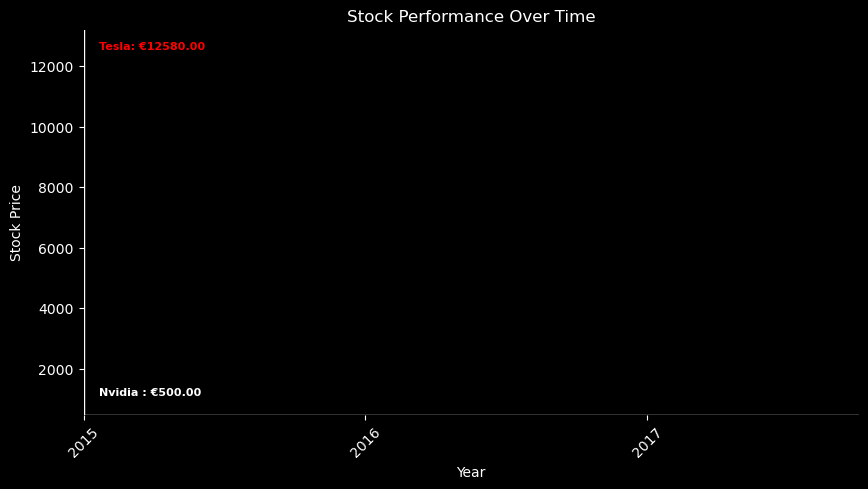

In [311]:
# === SET UP PLOT ===
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlabel("Year")
ax.set_ylabel("Stock Price")
ax.set_title("Stock Performance Over Time")

# Remove all spines (border lines)
for spine in ax.spines.values():
    spine.set_visible(False)



# === INITIALIZE LINES AND TEXT LABELS ===
lines = {stock: ax.plot([], [], label=stock, color=colors.get(stock, "white"), lw=2)[0] for stock in stock_columns}
text_labels = {stock: ax.text(0, 0, "", color=colors.get(stock, "white"), fontsize=12, fontweight='bold') for stock in stock_columns}

# === ANIMATION FUNCTION ===
def animate(i):
    if i >= len(df):
        return
    
    progress = i / len(df) * 100

    ax.clear()
    ax.set_xlabel("Year")
    ax.set_ylabel("Stock Price")
    ax.set_title("Stock Performance Over Time")

    # Dynamic X-axis scaling (show only the years)
    ax.set_xticks(year_positions)  # Position ticks at year changes
    ax.set_xticklabels(unique_years, rotation=45)  # Display only unique years

    # Increase the x_limit as the progress increases
    x_min = 0
    x_max = i + len(df) * 0.2*(1-progress/100) + len(df) * 0.05

    ax.set_xlim(x_min, x_max)


    # Dynamic Y-axis scaling
    if i == 0:
        ymin = min(df[stock][:1].min() for stock in stock_columns) * 0.95
        ymax = max(df[stock][:1].max() for stock in stock_columns) * 1.05
    else:
        ymin = min(df[stock][:i].min() for stock in stock_columns) * 0.95
        ymax = max(df[stock][:i].max() for stock in stock_columns) * 1.05

    ax.set_ylim(ymin, ymax)

    for stock in stock_columns:
        color = colors.get(stock, "white")

        # Plot line
        ax.plot(df.index[:i], df[stock][:i], label=stock, color=color, lw=2)

        value = df[stock][i]

        # Ensure text stays within bounds of the y-axis
        buffer_y = (ymax - ymin) * 0.05  # 5% buffer to avoid text getting cut off
        text_y_pos = max(min(df[stock][i] * 1.05, ymax - buffer_y), ymin + buffer_y)

        # Ensure text stays within bounds of the x-axis
        buffer_x = (x_max - x_min) * 0.02  # 2% buffer to avoid text going out
        text_x_pos = max(min(df.index[i], x_max - buffer_x), x_min + buffer_x)

        # Update labels dynamically
        ax.text(text_x_pos, text_y_pos, f"{stock}: €{value:.2f}", color=color, fontsize=8, fontweight='bold')

    # Keep only the x and y axes
    ax.axhline(y=ymin, color="white", linewidth=1)
    ax.axvline(x=0, color="white", linewidth=1)

# === CREATE ANIMATION ===
ani = animation.FuncAnimation(fig, animate, frames=len(df) + 50, interval=frame_interval)

# === SAVE ANIMATION ===
mp4_filename = 'stock_animation.mp4'
ani.save(mp4_filename, writer='ffmpeg', fps=fps)